In [301]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
import time
import pandas as pd
import math
from scipy.spatial import distance
from pyproj import Proj,transform
v84 = Proj(proj="latlong",towgs84="0,0,0",ellps="WGS84")
v36 = Proj(proj="latlong", k=0.9996012717, ellps="airy", towgs84="446.448,-125.157,542.060,0.1502,0.2470,0.8421,-20.4894")
vgrid = Proj(init="world:bng")
#Calculate Euclidean distances using Haversine formula

# Put into Easting/northing coord (as in UK model)

In [306]:
def dfLLtoEN(df):
    """Returns easting, northing tuple
    """
    vlon36, vlat36 = transform(v84,v36,df["long"].values,df["lat"].values)
    result = vgrid(vlon36,vlat36)

    # Transform the output to a Dataframe
    eastnorth = pd.DataFrame(index=df.index)
    for i in result:
        eastnorth["Easting"] = result[0]
        eastnorth["Northing"] = result[1]

    return round(eastnorth)

# Get data

In [307]:
Path = '../StudyGroup/'
CompleteData=pd.read_csv(Path+"completeData2.csv",header = 0)
CompleteData = CompleteData.drop(columns = 'Unnamed: 0')

In [308]:
N = len(CompleteData)
CompleteData = CompleteData.rename(index=str, columns={'X__1': "study"})

In [336]:
xmax = np.max(CompleteData['Easting'].values)
xmin = np.min(CompleteData['Easting'].values)
ymax = np.max(CompleteData['Northing'].values)
ymin = np.min(CompleteData['Northing'].values)
sizex = xmax-xmin
sizey = ymax-ymin
CompleteData['xcoord'] = CompleteData['Easting'] - xmin
CompleteData['ycoord'] = CompleteData['Northing'] - ymin

In [337]:
joinedinput = np.column_stack((xcoord, ycoord))
dist = distance.cdist(joinedinput, joinedinput, 'euclidean')

# I think divide by 1000 to get into Km - CHECK THIS!!!

In [352]:
dist = dist/1000 #into km

# Plots to explore the data, notice each study is a different scale

<IPython.core.display.Javascript object>


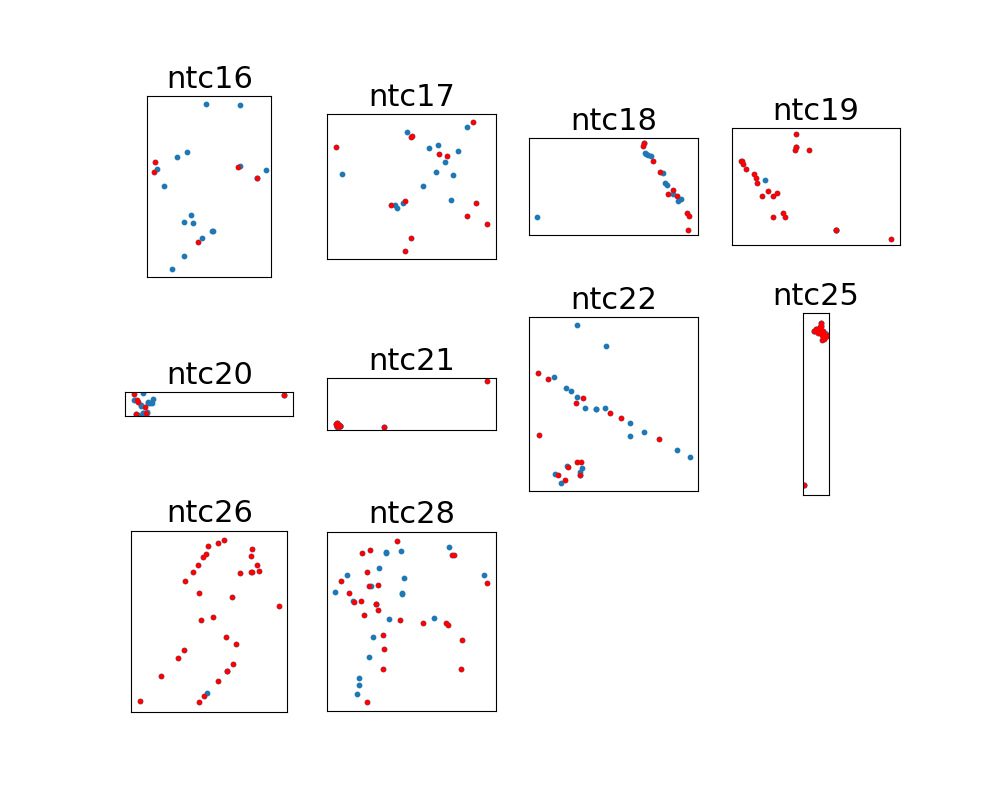

In [446]:
plt.figure(figsize = (10,8
            ))
#Plot spatial distribution of farms sharing water/grazing areas for each study
ind = 0
for index, value in enumerate(CompleteData['study'].unique()):
    stud = CompleteData[CompleteData['study']==value]
    if stud['lat'][stud['water_grazing'] == 1].empty == False:
        ind +=1
        plt.subplot(3,4, ind)
        plt.scatter(stud['xcoord'], stud['ycoord'], s = 10, label = 'location of farm')
        plt.scatter(stud['xcoord'][stud['water_grazing'] == 1], stud['ycoord'][stud['water_grazing'] == 1], c = 'red', s = 8, label = 'farm uses shared water')
        plt.title('{}'.format(value), fontsize = 22)
        plt.xticks([],[]) #anonymizing
        plt.yticks([],[]) #anonymizing
        plt.axis('scaled') #doesn't strech plots, disassort things
#         if index == 0:
# #             plt.legend(loc = 'lower center', fontsize = 18)

# All studies together

<IPython.core.display.Javascript object>


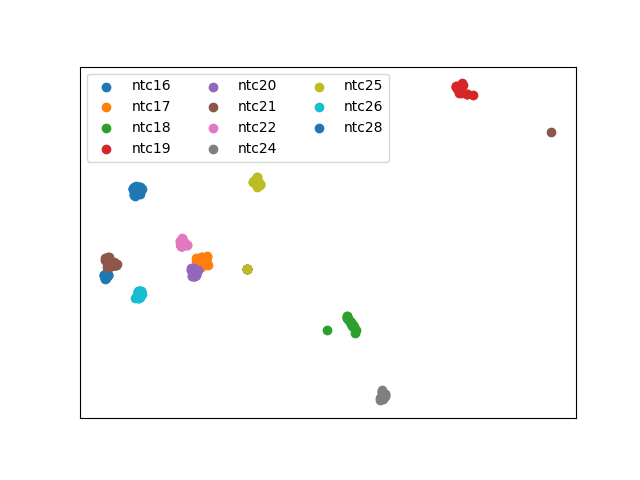

In [455]:
%matplotlib notebook
for index, value in enumerate(CompleteData['study'].unique()):
    stud = CompleteData[CompleteData['study']==value]
    plt.scatter(stud['xcoord'], stud['ycoord'], label = '{}'.format(value))
plt.legend(loc = 'upper left',ncol = 3)
plt.axis('scaled')
plt.xticks([],[])
plt.yticks([],[])
plt.show()


# histogram of distances between all farms in all studies

<IPython.core.display.Javascript object>


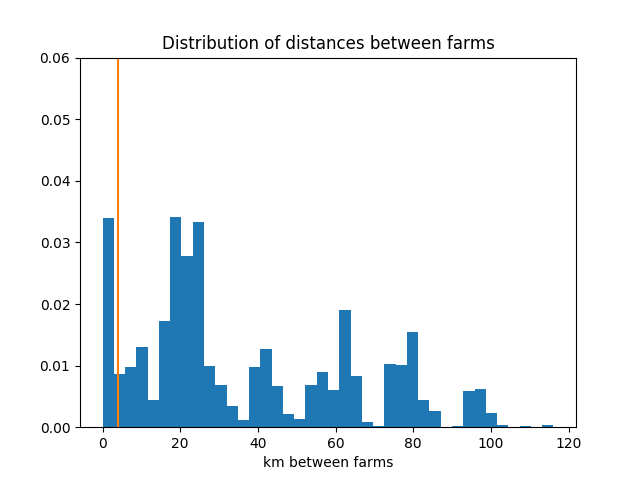

Text(0.5,1,'Distribution of distances between farms')

In [367]:
%matplotlib notebook
plt.hist((dist).flatten()[~np.isnan(dist.flatten())], bins = 40, normed = True)
plt.xlabel('km between farms')
plt.plot(4*np.ones(5), np.linspace(0,1, 5))
plt.ylim(0,0.06)
plt.title('Distribution of distances between farms')

# Interesting for study 24, didn't predict any shared water or grazing

<IPython.core.display.Javascript object>


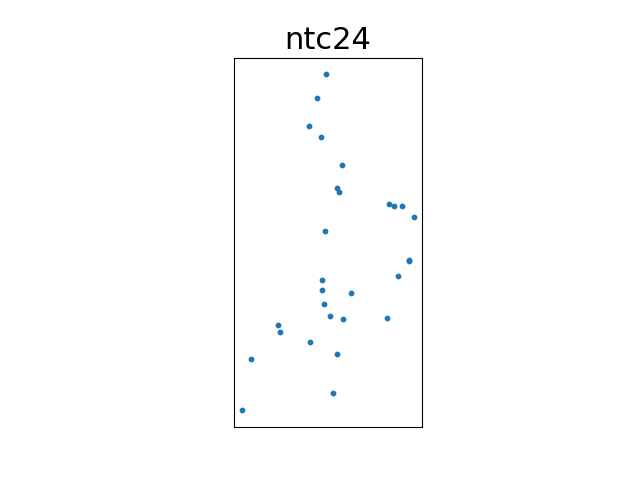

In [449]:
# plt.figure(figsize = (5,5))
#Plot spatial distribution of farms sharing water/grazing areas for each study
ind = 0
for index, value in enumerate(CompleteData['study'].unique()):
    stud = CompleteData[CompleteData['study']==value]
    if stud['lat'][stud['water_grazing'] == 1].empty:
        ind +=1
#         plt.subplot(2,3, ind)
        plt.scatter(stud['xcoord'], stud['ycoord'],s = 10, label = 'location of farm')
        plt.scatter(stud['xcoord'][stud['water_grazing'] == 1], stud['ycoord'][stud['water_grazing'] == 1], c = 'red', label = 'farm uses shared water')
        plt.title('{}'.format(value), fontsize = 22)
        plt.xticks([],[]) #anonymizing
        plt.yticks([],[]) #anonymizing
        plt.axis('scaled')
        if index == 0:
            plt.legend(loc = 'upper left', fontsize = 18)

# Plot of FMD in the last 6 months

<IPython.core.display.Javascript object>


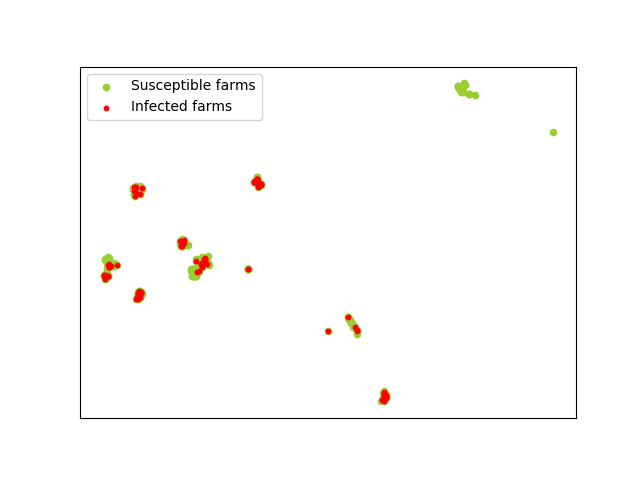

In [450]:
%matplotlib notebook
plt.scatter(xcoord, ycoord,c= 'yellowgreen', s= 20, label = 'Susceptible farms')
plt.scatter(CompleteData[CompleteData['fmd']==1]['xcoord'].values, CompleteData[CompleteData['fmd']==1]['ycoord'].values, s=10, c='r', label ='Infected farms')
plt.axis('scaled')
plt.xticks([],[])
plt.yticks([],[])
plt.legend(loc = 'upper left')

# Set up for the UK model

In [355]:
cattle = CompleteData['cattle'].values
sheep = CompleteData['sr'].values
vac = CompleteData['vaccine'].values
wg = CompleteData['water_grazing'].values

In [377]:
#Parameter values
        
psi = 0.00657
nu = 1.99*(10**(-7))
xi = 4.65
zeta = 2.80
chi = 0.403
phi = 0.799
rho = 0.000863
epsilon = 0.20 #Vaccine parameter
s = np.random.negative_binomial(50, 50/55, 342) #Draw latent periods
r = np.random.negative_binomial(30, 30/38, 342) #Draw infectious periods

#Calculate distance kernel
K = psi/(psi**2 + dist**2)   

5.055555555555555


In [357]:
#Calculate susceptibility

beta1 = np.zeros(342)
beta1 = nu*(xi*(cattle)**chi + (sheep)**chi)

for i in range(0,342):
    if (CompleteData['vaccine'][i] == 1):
       beta1[i] = epsilon*beta1[i]

# Below is the same model as for UK (cauchy) doesn't take into account other attributes

- does a bad job, none of the farms infect any other
- added in a different sero type being introduced into the environment every 1/4 of a year, did nothing

<IPython.core.display.Javascript object>


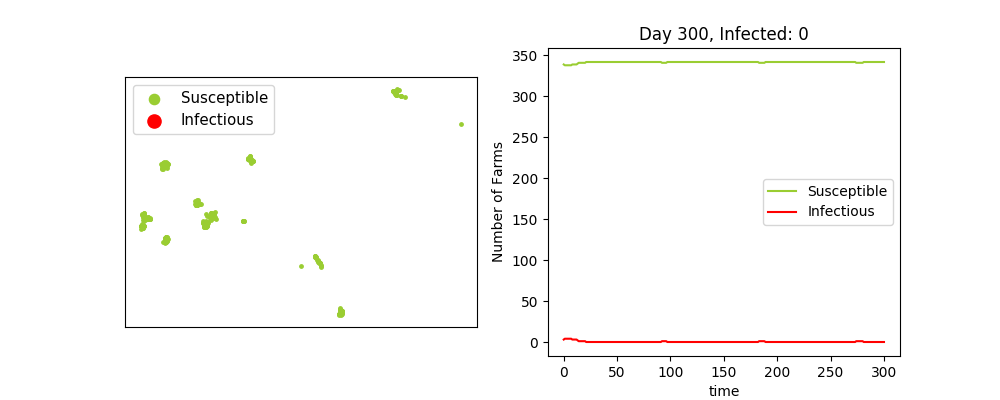

In [456]:
for i in range(1):
#Choose initial cases
       
    t = 0
    A = np.zeros(shape=(N,5))
    output = np.zeros(shape=(1000,6))     
    numInf = np.zeros(10000)  

    initial1 = random.randint(0,N)
    initial2 = initial1+1
    initial3 = initial2+1
    I = np.zeros(N)
    I[initial1] = 2
    I[initial2] = 2
    I[initial3] = 2
    A[0, ] = [initial1, 0, s[initial1], r[initial1], vac[initial1]]
    A[1, ] = [initial2, 0, s[initial2], r[initial2], vac[initial2]]
    A[2, ] = [initial3, 0, s[initial3], r[initial3], vac[initial3]]
    
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    susceptind = [i for i in range(np.size(I)) if I[i] ==0]
    
    
    Inf=[len(infectind)]
    Sus = [len(susceptind)]
    time_plot=[0]
    %matplotlib notebook
    start_time = time.time()
    fig = plt.figure(figsize = (10,4))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    plt.ion

    fig.show()
    fig.canvas.draw()
    
    while t<300:
        
        if (t%91)==0:
            newserotype = random.randint(0,N)
            I[newserotype] = 2
            A[newserotype, ] = [newserotype, t, s[newserotype], r[newserotype], vac[newserotype]]
#             print(t+s[newserotype])
        #Calculate transmission rate

        numInf[t] = sum(I == 2)
        t = t + 1
#         print("Day", t, "Susceptible", sum(I == 0), "Exposed", sum(I == 1), "Infected", sum(I == 2))

        beta = np.zeros(N)

        for j in range(0,N):
            beta[j] = beta1[j]*(np.sum((zeta*(cattle[I == 2]**chi) + sheep[I == 2]**chi)*K[I == 2, j]))
        
        #Calculate probability of infection

        prob_inf = (1 - np.exp(-beta)) #why is there a 5 here?
        

        #Infect if probability is less that a uniform sample

        unif = np.random.uniform(0, 1, N)

        for i in range(0,N):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                I[i] =  1
                su = sum(I != 0)
                A[su-1, ] = [i, t, s[i], r[i], vac[i]]
                print("Farm", i, "Day", t)

        #Update states

        inf = A[:,0][A[:,1] + A[:,2] == t] #Move to I state once latent period is over
        I[inf.astype(np.int64)] = 2
        rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to S state once infectious period is over
#         print(rem, t)
        I[rem.astype(np.int64)] = 0
        
        
        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i]==0]


        Inf.append(len(infectind))
        Sus.append(len(susceptind))
        
        time_plot.append(t)



        xinfectplot = xcoord[infectind]
        yinfectplot = ycoord[infectind]
        xsusceptplot = xcoord[susceptind]
        ysusceptplot = ycoord[susceptind]


        ax.clear()
        
        ax1.clear()
       
    
        ax1.plot(time_plot,Sus,label='Susceptible', c='yellowgreen')
        ax1.plot(time_plot,Inf,label='Infectious', c='r')
        plt.xlabel('time')
        plt.ylabel('Number of Farms')
        ax1.legend()
        
        
        ax.scatter(xsusceptplot, ysusceptplot, c='yellowgreen', marker='o', s=6, label='Susceptible')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
        ax.axis([0, np.max(xcoord), 0, np.max(ycoord)])

        plt.title('Day {}, Infected: {}'.format(t, np.size(xinfectplot)),fontsize = 12)
        ax.axis('scaled')
        ax.legend(loc = 'upper left', fontsize = 10.8,  markerscale= 3)

        
        
        fig.canvas.draw()
        #Store output

        if len(rem) > 0:
            for i in range(0,len(rem)):
                output[out + i,] = [rem[i], t - A[i,2] - A[i,3], xcoord[rem.astype(np.int64)[i]], ycoord[rem.astype(np.int64)[i]], cattle[rem.astype(np.int64)[i]], sheep[rem.astype(np.int64)[i]]]

    output = output[0:out,]

#     plt.scatter(xcoord[I == 2], ycoord[I == 2], c = 'red')

# Add in additional interactions between farms, based on if they're less than 10km away and share: water, milk, grazing and equipment

<IPython.core.display.Javascript object>


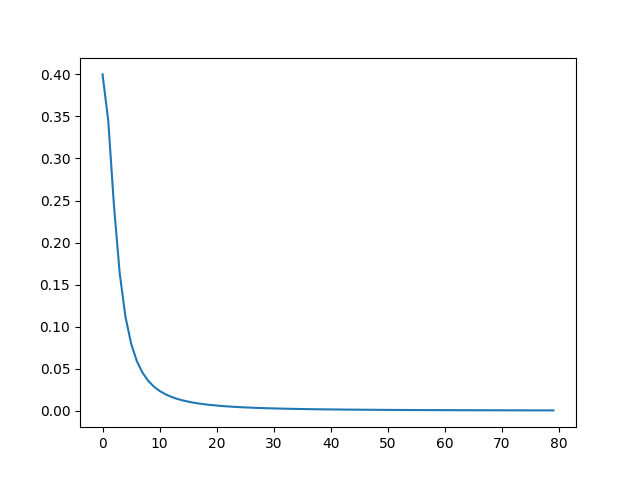

In [457]:
%matplotlib notebook
ψ = 2.5 #changed the distance kernel
plt.plot(range(80), [ψ/(ψ**2+x**2) for x in range(80)])

# things
- found for every farm that said they shared equipment, milk, water, grazing, found all farms in a 10km euclidean distance from them and put a 1 - IS 10KM A GOOD GUESS, (going off they wouldn't go more than 4km for water)
- did this for contact_animal and people but put no restriction as they can be at markets - SHOULD WE ADD A DISTANCE
- need to fit for a1-a7, assumed them all to be 1 for now (BAD ASSUMPTION)
- see if any attributes are correlated, reject them
- Then I multiplied each column (which corresponds to a farm j for all i, transmission_matrix[:,j]) by the number of livestock on that farm, with the $\nu$ and $\chi$ terms. So this matrix contains number of livestock on infected farms:

When we calculate


$\beta[j]$ = Number_livestock_on_j x Tranmission_matrix_row_j_all_infected_farms_column x
Kerneldist_distance_between_rows_of_all_infected_farms_and_column_j


In [384]:
rounddist =np.around(dist,decimals = 1)
kerneldist = 2.5/(2.5**2 + rounddist**2)

shares_equipment = np.zeros(shape = (N,N)) #cap at 10km
shares_water = np.zeros(shape = (N,N)) #cap at 10km
shares_grazing = np.zeros(shape=(N,N)) #cap at 10km
shares_milk = np.zeros(shape = (N,N)) #cap at 10km
shares_vet = np.zeros(shape = (N,N)) #cap at 10km
contactanimal = np.zeros(shape = (N,N))
contacthuman = np.zeros(shape = (N,N)) 


for i in range(N):
    for j in range(N):
        if i != j:
            if dist[i,j] <= 10:
                if (CompleteData['milk'][[i]].values==1 and CompleteData['milk'][[j]].values ==1):
                    shares_milk[i,j] = 1
                if (CompleteData['water'][[i]].values==1 and CompleteData['water'][[j]].values ==1):
                    shares_water[i,j] =1
                if (CompleteData['grazing'][[i]].values==1 and CompleteData['grazing'][[j]].values ==1):
                    shares_grazing[i,j] =1
                if (CompleteData['equipment'][[i]].values==1 and CompleteData['equipment'][[j]].values ==1):
                    shares_equipment[i,j] =1
                if (CompleteData['vet'][[i]].values==1 and CompleteData['vet'][[j]].values ==1):
                    shares_vet[i,j] = 1
            if (CompleteData['contact_animal'][[i]].values==1 and CompleteData['contact_animal'][[j]].values ==1):
                contactanimal[i,j] = 1
            if (CompleteData['contact_people'][[i]].values==1 and CompleteData['contact_people'][[j]].values ==1):
                contacthuman[i,j] = 1

In [432]:
CompleteData.columns.values
a1 = 1
a2 = 1
a3 = 1
a4 = 1
a5 =1 
a6 =1
a7 =1
transmission_matrix = (a1*shares_equipment+
 a2*shares_water+
 a3*shares_grazing + 
 a4*shares_milk + 
 a5*shares_vet + 
 a6*contactanimal + 
 a7*contacthuman)

beta2 = nu*cattle*chi+sheep*chi


for i in range(N):
    transmission_matrix[:,i] *= (beta2)[i]



# Actually get some SI spread (hits peak and then fluctuates)

<IPython.core.display.Javascript object>


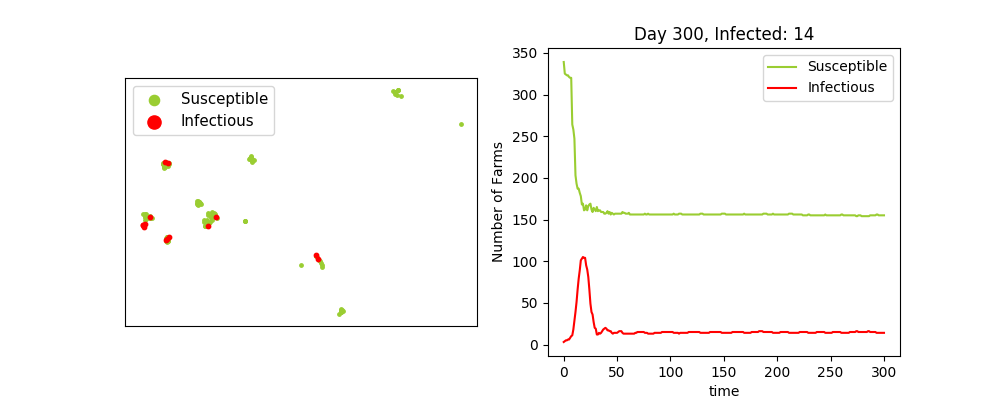

In [458]:
for i in range(1):
#Choose initial cases
       
    t = 0
    A = np.zeros(shape=(N,5))
    output = np.zeros(shape=(1000,6))     
    numInf = np.zeros(10000)  

    initial1 = random.randint(0,N)
    initial2 = initial1+1
    initial3 = initial2+1
    I = np.zeros(N)
    I[initial1] = 2
    I[initial2] = 2
    I[initial3] = 2
    A[0, ] = [initial1, 0, s[initial1], r[initial1], vac[initial1]]
    A[1, ] = [initial2, 0, s[initial2], r[initial2], vac[initial2]]
    A[2, ] = [initial3, 0, s[initial3], r[initial3], vac[initial3]]
    
    infectind = [i for i in range(np.size(I)) if I[i]==2]
    susceptind = [i for i in range(np.size(I)) if I[i] ==0]
    
    
    Inf=[len(infectind)]
    Sus = [len(susceptind)]
    time_plot=[0]
    %matplotlib notebook
    start_time = time.time()
    fig = plt.figure(figsize = (10,4))
    ax = fig.add_subplot(121)
    ax1 = fig.add_subplot(122)
    plt.ion

    fig.show()
    fig.canvas.draw()
    
    while t<300:
        
        if (t%91)==0:
            newserotype = random.randint(0,N)
            I[newserotype] = 2
            A[newserotype, ] = [newserotype, t, s[newserotype], r[newserotype], vac[newserotype]]
#             print(t+s[newserotype])
        #Calculate transmission rate

        numInf[t] = sum(I == 2)
        t = t + 1
#         print("Day", t, "Susceptible", sum(I == 0), "Exposed", sum(I == 1), "Infected", sum(I == 2))

        beta = np.zeros(N)

        for j in range(0,N):
#             print(transmission_matrix[j,I==2]*kerneldist[I == 2, j])
            beta[j] = beta2[j]*np.matrix(transmission_matrix)[j,I==2]*np.matrix(kerneldist)[I == 2, j]
#             print(beta[j])
        #Calculate probability of infection

        prob_inf = (1 - np.exp(-beta)) #why is there a 5 here?
        

        #Infect if probability is less that a uniform sample

        unif = np.random.uniform(0, 1, N)

        for i in range(0,N):
            if (unif[i] <= prob_inf[i] and I[i] == 0):
                I[i] =  1
                su = sum(I != 0)
                A[su-1, ] = [i, t, s[i], r[i], vac[i]]
#                 print("Farm", i, "Day", t)

        #Update states

        inf = A[:,0][A[:,1] + A[:,2] == t] #Move to I state once latent period is over
        I[inf.astype(np.int64)] = 2
        rem = A[:,0][A[:,1] + A[:,2] + A[:,3] == t] #Move to S state once infectious period is over
#         print(rem, t)
        I[rem.astype(np.int64)] = 0
        
        
        infectind = [i for i in range(np.size(I)) if I[i]==2]
        susceptind = [i for i in range(np.size(I)) if I[i]==0]


        Inf.append(len(infectind))
        Sus.append(len(susceptind))
        
        time_plot.append(t)



        xinfectplot = xcoord[infectind]
        yinfectplot = ycoord[infectind]
        xsusceptplot = xcoord[susceptind]
        ysusceptplot = ycoord[susceptind]


        ax.clear()
        
        ax1.clear()
       
    
        ax1.plot(time_plot,Sus,label='Susceptible', c='yellowgreen')
        ax1.plot(time_plot,Inf,label='Infectious', c='r')
        plt.xlabel('time')
        plt.ylabel('Number of Farms')
        ax1.legend()
        
        
        ax.scatter(xsusceptplot, ysusceptplot, c='yellowgreen', marker='o', s=6, label='Susceptible')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.scatter(xinfectplot, yinfectplot, c='r', marker='o', s=10, label='Infectious')
        ax.axis([0, np.max(xcoord), 0, np.max(ycoord)])

        plt.title('Day {}, Infected: {}'.format(t, np.size(xinfectplot)),fontsize = 12)
        ax.axis('scaled')
        ax.legend(loc = 'upper left', fontsize = 10.8,  markerscale= 3)

        
        
        fig.canvas.draw()
        #Store output

        if len(rem) > 0:
            for i in range(0,len(rem)):
                output[out + i,] = [rem[i], t - A[i,2] - A[i,3], xcoord[rem.astype(np.int64)[i]], ycoord[rem.astype(np.int64)[i]], cattle[rem.astype(np.int64)[i]], sheep[rem.astype(np.int64)[i]]]

    output = output[0:out,]

#     plt.scatter(xcoord[I == 2], ycoord[I == 2], c = 'red')